<div style="text-align: left">
    <img src='https://github.com/CLAIR-LAB-TECHNION/CLAI/blob/main/tutorials/assets/logo.png?raw=true' width=800/>  
</div>

Author: Itay Segev

E-mail: [itaysegev@campus.technion.ac.il](mailto:itaysegev@campus.technion.ac.il)



# Value Based Methods




<img src='https://github.com/CLAIR-LAB-TECHNION/CLAI/blob/main/tutorials/assets/tut04_creation_of_ai.png?raw=true' width=900/>


<a id="section:intro"></a>

# <img src="https://img.icons8.com/?size=50&id=55412&format=png&color=000000" style="height:50px;display:inline"> Introduction
---

In reinforcement learning, **value-based methods** are crucial for estimating the value of states and actions, helping agents make optimal decisions. This tutorial covers key concepts in value-based methods, focusing on **Tabular Q-Learning**. Value functions, including the state-value function $V(s)$ and action-value function $Q(s, a)$, represent the expected return of states and actions, guiding the agent towards the optimal policy $\pi^*$. Tabular Q-Learning, a foundational algorithm, uses a Q-table to store Q-values for state-action pairs, updating them through temporal difference learning to find the optimal action-value function $Q^*(s, a)$. Key topics include Bellman equations, temporal difference learning, the Q-Learning algorithm, and balancing exploration and exploitation.


# <img src="https://img.icons8.com/?size=50&id=43171&format=png&color=000000" style="height:30px;display:inline"> Setup


You will need to make a copy of this notebook in your Google Drive before you can edit the notebook. You can do so with **File &rarr; Save a copy in Drive**.

In [1]:
#@title mount your Google Drive
import os
connect_drive = False #@param {type: "boolean"}
if connect_drive:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  # set up mount symlink
  DRIVE_PATH = '/content/gdrive/My\ Drive/cs236203_s24'
  DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
  if not os.path.exists(DRIVE_PYTHON_PATH):
    %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/cs236203_s24'
if not os.path.exists(SYM_PATH) and connect_drive:
  !ln -s $DRIVE_PATH $SYM_PATH




In [2]:
#@title apt install requirements

#@markdown Run each section with Shift+Enter

#@markdown Double-click on section headers to show code.

from IPython.display import clear_output

!sudo apt-get update
!sudo apt-get install -y python3-opengl
!apt install ffmpeg xvfb
!pip3 install pyvirtualdisplay
!pip install gymnasium

clear_output()

To make sure the new installed libraries are used, **sometimes it's required to restart the notebook runtime**. The next cell will force the **runtime to crash, so you'll need to connect again and run the code starting from here**. Thanks to this trick, **we will be able to run our virtual screen.**

In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
#@title set up virtual display

from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

## Import the packages

In addition to the installed libraries, we also use:

- `random`: To generate random numbers (that will be useful for epsilon-greedy policy).
- `imageio`: To generate a replay video.

In [3]:
import numpy as np
import gymnasium as gym
import random
import imageio
import os
import tqdm

from tqdm.notebook import tqdm




# <img src="https://img.icons8.com/?size=50&id=8GlFeky9HXyQ&format=png&color=000000" style="height:30px;display:inline"> The FrozenLake-v1 Environment



The [Frozen Lake environment](https://gymnasium.farama.org/environments/toy_text/frozen_lake) is a classic navigation task in reinforcement learning. It is designed to test the basic capabilities of an RL algorithm in a grid world setting. Here’s a detailed description of the environment:

We're going to train our Q-Learning agent **to navigate from the starting state (S) to the goal state (G) by walking only on frozen tiles (F) and avoid holes (H)**.

We can have two sizes of environment:

- `map_name="4x4"`: a 4x4 grid version
- `map_name="8x8"`: a 8x8 grid version


The environment has two modes:

- `is_slippery=False`: The agent always moves **in the intended direction** due to the non-slippery nature of the frozen lake (deterministic).
- `is_slippery=True`: The agent **may not always move in the intended direction** due to the slippery nature of the frozen lake (stochastic).


<img src='https://gymnasium.farama.org/_images/frozen_lake.gif' width=600/>

For now let's keep it simple with the 4x4 map and non-slippery.
We add a parameter called `render_mode` that specifies how the environment should be visualised. In our case because we **want to record a video of the environment at the end, we need to set render_mode to rgb_array**.

As [explained in the documentation](https://gymnasium.farama.org/api/env/#gymnasium.Env.render) “rgb_array”: Return a single frame representing the current state of the environment. A frame is a np.ndarray with shape (x, y, 3) representing RGB values for an x-by-y pixel image.

In [4]:
env_id = "FrozenLake-v1"
# Create the env
env = gym.make(env_id, map_name="4x4", is_slippery=False, render_mode="rgb_array")

## <img src="https://img.icons8.com/?size=50&id=46589&format=png&color=000000" style="height:30px;display:inline"> Task 1: Getting Familiar with the FrozenLake Environment



<img src='https://github.com/CLAIR-LAB-TECHNION/CLAI/blob/main/tutorials/assets/task_sign.png?raw=true' width=800/>

In this task, you will explore the FrozenLake-v1 environment. Your objective is to understand the basic operations of this environment, such as resetting the environment, taking actions, and observing the outcomes.

Questions:
- What are the dimensions of the state space?
- What are the possible actions in the action space?
- What triggers the termination of an episode in FrozenLake-v1?

<img src='https://github.com/CLAIR-LAB-TECHNION/CLAI/blob/main/tutorials/assets/solution_sign.png?raw=true' width=800/>

#### <img src="https://img.icons8.com/?size=50&id=42816&format=png&color=000000" style="height:30px;display:inline">  Solution



In [5]:
# We create our environment with gym.make("<name_of_the_environment>")- `is_slippery=False`: The agent always moves in the intended direction due to the non-slippery nature of the frozen lake (deterministic).
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space", env.observation_space)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

Observation Space Discrete(16)
Sample observation 2


We see with `Observation Space Shape Discrete(16)` that the observation is an integer representing the **agent’s current position as current_row * ncols + current_col (where both the row and col start at 0)**.

For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15. The number of possible observations is dependent on the size of the map. **For example, the 4x4 map has 16 possible observations.**


For instance, this is what state = 0 looks like:

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit2/frozenlake.png" alt="FrozenLake">

In [7]:
print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape", env.action_space)
print("Action Space Sample", env.action_space.sample()) # Take a random action


 _____ACTION SPACE_____ 

Action Space Shape Discrete(4)
Action Space Sample 2


The action space is **discrete**, consisting of four possible actions:

1. Move Left: Move the agent to the left.
2. Move Down: Move the agent downwards.
3. Move Right: Move the agent to the right.
4. Move Up: Move the agent upwards.

The agent receives a reward 💰 of +1 for reaching the goal tile and 0 otherwise. The goal is to maximize the total reward over an episode.

An episode ends if any of the following conditions are met:

- The agent reaches the goal tile.
- The agent falls into a hole.
- The episode reaches a maximum number of steps.

You can create your own custom grid like this:

```python
desc=["SFFF", "FHFH", "FFFH", "HFFG"]
gym.make('FrozenLake-v1', desc=desc, is_slippery=True)
```

but we'll use the default environment for now.

# <img src="https://img.icons8.com/?size=50&id=53819&format=png&color=000000" style="height:30px;display:inline"> Value-based methods



Our goal is to find an optimal policy $\pi^*$ , aka., a policy that leads to the best expected cumulative reward.

And to find this optimal policy (hence solving the RL problem), there are two main types of RL methods:

* Policy-based methods: Train the policy directly to learn which action to take given a state.

* Value-based methods: Train a value function to learn which state is more valuable and use this value function to take the action that leads to it.



In the case of **value-based methods**, you don’t train the policy: your policy is just a simple pre-specified function (for instance, the Greedy Policy) that uses the values given by the value-function to select its actions.

In **policy-based** training, the optimal policy (denoted $\pi^*$) is found by training the policy directly.
In value-based training, finding an optimal value function (denoted $Q^*$ or $V^*$, we’ll study the difference below) leads to having an optimal policy.

<img src='https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/two-approaches.jpg' width=800/>

## <img src="https://img.icons8.com/?size=50&id=110869&format=png&color=000000" style="height:30px;display:inline"> Value Functions


In reinforcement learning, value functions are essential mathematical constructs that help us design and conceptualize algorithms. They provide a way to evaluate the expected return (sum of rewards) starting from a given state or state-action pair and following a particular policy. Value functions are crucial for understanding and optimizing the reinforcement learning objective.


### Types of Value Functions

There are four primary value functions to consider:

1. **On-Policy Value Function $V^{\pi}(s)$**: This function gives the expected return if you start in state $s$ and always act according to policy $\pi$. Mathematically, it is defined as:

   $
   V^{\pi}(s) = \mathbb{E}_{\tau \sim \pi}[R(\tau) \mid s_0 = s]
   $

   where $R(\tau)$ is the return of trajectory $\tau$.

2. **On-Policy Action-Value Function $Q^{\pi}(s,a)$**: This function provides the expected return if you start in state $s$, take an arbitrary action $a$ (which may not have come from the policy), and then forever after act according to policy $\pi$:

   $
   Q^{\pi}(s,a) = \mathbb{E}_{\tau \sim \pi}[R(\tau) \mid s_0 = s, a_0 = a]
   $

3. **Optimal Value Function $V^*(s)$**: This function gives the expected return if you start in state $s$ and always act according to the optimal policy in the environment:

   $
   V^*(s) = \max_{\pi} \mathbb{E}_{\tau \sim \pi}[R(\tau) \mid s_0 = s]
   $

4. **Optimal Action-Value Function $Q^*(s,a)$**: This function provides the expected return if you start in state $s$, take an arbitrary action $a$, and then forever after act according to the optimal policy in the environment:

   $
   Q^*(s,a) = \max_{\pi} \mathbb{E}_{\tau \sim \pi}[R(\tau) \mid s_0 = s, a_0 = a]
   $


### Recursive Nature of Value Functions

Value functions can be written recursively, leveraging the concept of causality—decisions at a current time step do not affect past rewards. This recursive nature allows us to break down the expected return into a series of nested expectations.

For example, the on-policy action-value function $Q^{\pi}(s,a)$ can be expressed as:

$
Q^{\pi}(s,a) = r(s,a) + \gamma \mathbb{E}_{s'}[V^{\pi}(s') \mid s, a]
$

where $r(s,a)$ is the immediate reward and $\gamma$ is the discount factor.

Similarly, the on-policy value function $V^{\pi}(s)$ can be written in terms of the action-value function:

$
V^{\pi}(s) = \mathbb{E}_{a \sim \pi}[Q^{\pi}(s,a)]
$

### Connections Between Value Functions

There are two key connections between the value function and the action-value function:

1. **Expected Value**:
   $
   V^{\pi}(s) = \mathbb{E}_{a \sim \pi}[Q^{\pi}(s,a)]
   $
   This relation shows that the value of a state under policy $\pi$ is the expected value of the action-value function over actions taken according to $\pi$.

2. **Optimal Value**:
   $
   V^*(s) = \max_a Q^*(s,a)
   $
   This relation indicates that the optimal value of a state is the maximum action-value function over all possible actions.

### Importance of Value Functions

Value functions play a critical role in reinforcement learning for several reasons:

1. **Policy Evaluation**: They allow us to evaluate how good a policy is by estimating the expected return starting from a particular state or state-action pair.
2. **Policy Improvement**: By comparing value functions under different policies, we can systematically improve the policy. This is the basis of methods like policy iteration and Q-learning.
3. **Reducing Variance**: Using value functions, we can derive estimators with lower variance, which are more stable and reliable for learning.


### Value of a trajectory / of a policy

An oracle decides on how to choose actions at each time step:
$$\mathbb{P}(A_t)=\pi_t.$$

The collection of $\pi_t$ is the oracle's **policy**.


One policy implies one specific distribution over trajectories over the frozen lake. More generally, the policy and $S_0$ condition the sequence $S_0, A_0, R_0, S_1, A_1, R_1, \ldots$

In FrozenLake some trajectories are better than others. **We need a criterion to compare trajectories.** Intuitively, this criterion should reflect the idea that a good policy accumulates as much reward as possible along a trajectory.

Let's compare the policy that always moves to the right and the policy that always moves left by summing the rewards obtained along trajectories and then averaging these rewards across trajectories.

In [12]:
import gymnasium.envs.toy_text.frozen_lake as fl

nb_episodes = 50000
horizon = 200

Vright = np.zeros(nb_episodes)
for i in range(nb_episodes):
    env.reset()
    for t in range(horizon):
        next_state, r, terminated, truncated,_ = env.step(fl.RIGHT)
        Vright[i] += r
        if terminated or truncated:
            break

Vleft  = np.zeros(nb_episodes)
for i in range(nb_episodes):
    env.reset()
    for t in range(horizon):
        next_state, r, terminated, truncated,_ = env.step(fl.LEFT)
        Vleft[i] += r
        if terminated or truncated:
            break

print("est. value of 'right' policy:", np.mean(Vright), "variance:", np.std(Vright))
print("est. value of 'left'  policy:", np.mean(Vleft),  "variance:", np.std(Vleft))

est. value of 'right' policy: 0.0 variance: 0.0
est. value of 'left'  policy: 0.0 variance: 0.0


In the general case, this sum of rewards on an infinite horizon might be unbounded. So let us introduce the **$\gamma$-discounted sum of rewards** (from a starting state $s$, under policy $\pi$) random variable:
$$G^\pi(s) = \sum\limits_{t = 0}^\infty \gamma^t R_t \quad \Bigg| \quad \begin{array}{l}S_0 = s,\\ A_t \sim \pi_t,\\ S_{t+1}\sim p(\cdot|S_t,A_t),\\R_t = r(S_t,A_t,S_{t+1}).\end{array}$$

$G^\pi(s)$ represents what we can gain in the long-term by applying the actions from $\pi$.

Then, given a starting state $s$, we can define the value of $s$ under policy $\pi$:
$$V^\pi(s) = \mathbb{E} \left[ G^\pi(s) \right]$$

This defines the value function $V^\pi$ of policy $\pi$:
<div class="alert alert-success"><b>Value function $V^\pi$ of a policy $\pi$ under a $\gamma$-discounted criterion</b><br>
$$V^\pi : \left\{\begin{array}{ccl}
S & \rightarrow & \mathbb{R}\\
s & \mapsto & V^\pi(s)=\mathbb{E}\left( \sum\limits_{t = 0}^\infty \gamma^t R_t \bigg| S_0 = s, \pi \right)\end{array}\right. $$
</div>



Note that this definition is quite arbitrary: instead of the expected (discounted) sum of rewards, we could have taken the average reward over all time steps, or some other (more or less exotic) comparison criterion between policies.

Most of the RL literature uses this discounted criterion (in some cases with $\gamma=1$), some uses the average reward criterion, and few works venture into more exotic criteria. Today, we will limit ourselves to the discounted criterion.

### The Optimal Q-Function and the Optimal Action

There is a significant connection between the optimal action-value function $Q^*(s,a)$ and the action selected by the optimal policy. By definition, $Q^*(s,a)$ gives the expected return for starting in state $s$, taking an arbitrary action $a$, and then following the optimal policy thereafter.

The optimal policy in state $s$ will select the action that maximizes the expected return from $s$. Therefore, if we have $Q^*$, we can directly obtain the optimal action $a^*(s)$ as:

$$a^*(s) = \arg \max_a Q^*(s,a)$$

Note that there may be multiple actions which maximize $Q^*(s,a)$, in which case, all of them are optimal, and the optimal policy may randomly select any of them. However, there is always an optimal policy that deterministically selects an action.

## <img src="https://img.icons8.com/?size=50&id=77996&format=png&color=000000" style="height:30px;display:inline"> Bellman Equations



In reinforcement learning, all four of the value functions obey special self-consistency equations called Bellman equations. The basic idea behind the Bellman equations is:

The value of your starting point is the reward you expect to get from being there, plus the value of wherever you land next.



The Bellman equations for the on-policy value functions are:

$$
V^{\pi}(s) = \mathbb{E}_{a \sim \pi, \, s' \sim P}[r(s,a) + \gamma V^{\pi}(s')]
$$

$$
Q^{\pi}(s,a) = \mathbb{E}_{s' \sim P}[r(s,a) + \gamma \mathbb{E}_{a' \sim \pi}[Q^{\pi}(s',a')]]
$$



The Bellman equations for the optimal value functions are:

$$
V^*(s) = \max_a \mathbb{E}_{s' \sim P}[r(s,a) + \gamma V^*(s')]
$$

$$
Q^*(s,a) = \mathbb{E}_{s' \sim P}[r(s,a) + \gamma \max_{a'} Q^*(s',a')]
$$

The crucial difference between the Bellman equations for the on-policy value functions and the optimal value functions is the absence or presence of the $\max$ over actions. Its inclusion reflects the fact that whenever the agent gets to choose its action, in order to act optimally, it has to pick whichever action leads to the highest value.





The idea of the Bellman equation is that instead of calculating each value as the sum of the expected return, which is a long process, we calculate the value as the sum of the immediate reward plus the discounted value of the state that follows.

### <img src="https://img.icons8.com/?size=50&id=46812&format=png&color=000000" style="height:30px;display:inline"> Intuitions

The following section is designed to enhance your understanding of value functions and their applications. While it includes examples you may have encountered in an intro to AI course, we highly recommend reviewing this material. This foundation will ensure you are comfortable navigating the different ideas and terms used in value-based reinforcement learning methods.

Consider the maze below, where an agent can move North, South, East or West. The resulting transition is deterministic and a reward of $+1$ is gained when exiting the maze (which terminates the game). Otherwise all rewards are zero. Bumping into a wall terminates the game with a reward of zero.

<img src="https://github.com/RL-VS/rlvs2021/blob/main/docs/class-material/rl_fundamentals/img/grid_raw.png?raw=1" width="200px"></img>

Let's consider the policy $\pi$ that always moves East.

<img src="https://github.com/RL-VS/rlvs2021/blob/main/docs/class-material/rl_fundamentals/img/grid_policy.png?raw=1" width="200px"></img>


**Without writing any equation, what is the value of the top-right cell under this policy?**


**Answer:**

$V^\pi((3,3)) = 1$


**Now let's take $\gamma=0.9$.**

Without writing any equation, what is the value of the top-middle cell under this policy? What is the value of the bottom-right cell?


**Answer:**

The value of $(2,3)$ is the expected discounted sum of what one gets from applying $\pi$ from $(2,3)$. Since the $\pi$ is deterministic and the transitions are deterministic too, $\pi(2,3)$ always take us to state $(3,3)$. So $V^\pi((2,3)) = 0 + \gamma \times V^\pi((3,3)) = 0.9$.
    
The value of $(3,1)$ is the expected infinite sum of discounted rewards from $(3,1)$. Since the agent keeps bumping into the wall when applying $\pi$, it never exits the maze and this is an infinite sum of zero terms. Hence $V^\pi((2,3)) = 0$.
</div>
</div>

Let's draw the value function.

<img src="https://github.com/RL-VS/rlvs2021/blob/main/docs/class-material/rl_fundamentals/img/grid_vpi.png?raw=1" width="200px"></img>

Suppose you are currently in cell $(1,2)$ and would like to choose what action to take. Suppose also that you know the value function above. You need to put a scalar value on all four actions. To evaluate each action, let's estimate what we can get by applying the action and then using $\gamma \times V^\pi(s)$ to estimate what can obtain in the long run after this first action. Define $Q^\pi((x,y),a)$ as the utility we estimate for each action $a$ in $(x,y)$.

**Question**  
What is $Q^\pi((1,2),a)$ for action $a$ in $\{N,S,E,W\}$? What seems to be the most interesting first action to take, if we follow $\pi$ after?  


**Answer:**

$Q^\pi((1,2),N) = 0 + \gamma \cdot \gamma^2 = 0.729$  
$Q^\pi((1,2),S) = 0 + \gamma \cdot 0 = 0$  
$Q^\pi((1,2),E) = 0 + \gamma \cdot 0 = 0$  
$Q^\pi((1,2),W) = 0$  
The best action seems to be $N$.


An optimal policy is quite easy to guess. Let's draw the optimal value function (the value function of any optimal policy).

<img src="https://github.com/RL-VS/rlvs2021/blob/main/docs/class-material/rl_fundamentals/img/grid_vopt.png?raw=1" width="200px"></img>

Define $Q^*((x,y),a)$ as the utility we estimate for each action $a$ in $(x,y)$ if it is followed by an optimal policy.
<div class="alert alert-warning">
    
**Question**   
What is $Q^*((1,2),a)$ for action $a$ in $\{N,S,E,W\}$? What seems to be the most interesting first action to take, if we act optimally after? Rank the actions by utility.  


**Answer:**

$Q^*$ is what we gain immediately, plus $\gamma$ times what we expect to receive from applying an optimal policy in the state we reach by applying $a$.  
$Q^*((1,2),N) = 0 + \gamma\times\gamma^2=\gamma^3$  
$Q^*((1,2),S) = 0 + \gamma\times\gamma^4=\gamma^5$  
$Q^*((1,2),E) = 0 + \gamma\times\gamma^4=\gamma^5$  
$Q^*((1,2),W) = 0 + \gamma\times\gamma^3=\gamma^4$  
The best action seems to be $N$, followed by $W$, after that $S$ and $E$ are tied.



**Question**  
Now suppose $(1,2)$ is a special slippery cell. Going North has a $0.7$ probability of actually reaching $(1,3)$, but also a $0.2$ probability of staying in $(1,2)$ and a $0.1$ probability of ending in $(2,2)$. Note that this changes the problem and the optimal expected return function $V^*$.


Given this new problem, can you write $Q^*((1,2),N)$ as a function of $V^*(1,3)$, $V^*(1,2)$ and $V^*(2,2)$?


**Answer:**

When we take action $N$ in $(1,2)$, there are 3 possible outcomes:
- with probability $0.7$, reach $(1,3)$ and get reward $0$,
- with probability $0.2$, reach $(1,2)$ and get reward $0$,
- with probability $0.1$, reach $(2,2)$ and get reward $0$.

So what we can expect to get from applying $N$ in $(1,2)$ is:  

\begin{align*}
    Q^*((1,2), N) &= 0.7 \times (0+\gamma V^*(1,3)) + 0.2\times(0+\gamma V^*(1,2)) + 0.1\times(0+\gamma V^*(2,2))\\
    &= \gamma \left(0.7\times V^*(1,3) + 0.2\times V^*(1,2)+ 0.1\times V^*(2,2)\right)
\end{align*}
</div>
</div>

**Question**

Now you can remark that if we knew the action $\pi^*((1,2))$ taken by an optimal policy in $(1,2)$, then $Q^*((1,2), \pi^*(1,2))$ would actually be precisely the optimal long-term return $V^*$ (since it would be the expected return of a policy that acts optimally at every time step, including the first one).


Suppose an oracle tells us that $\pi^*((1,2))=N$. Using the previous exercice, write $V^*(1,2)$ as a function of $V^*(1,3)$, $V^*(1,2)$ and $V^*(2,2)$.


**Answer:**

We have $V^*((1,2)) = Q^*((1,2),N)$, so
$$V^*((1,2)) = \gamma \left(0.7\times V^*(1,3) + 0.2\times V^*(1,2)+ 0.1\times V^*(2,2)\right)$$


### <img src="https://img.icons8.com/?size=50&id=43167&format=png&color=000000" style="height:30px;display:inline"> Bellman Evaluation Operator

The following cells contain advanced mathematical tools and intuitions to understand the convergence of value-based methods. While this is not a complete proof, the main ideas are presented in a simplified manner to help you grasp the key concepts. For a more rigorous and detailed proof, we encourage you to explore the full explanation provided in this [book](https://github.com/avivt/RL-book-overleaf).


The Bellman evaluation operator, denoted as $T^\pi$, helps in evaluating a given policy by updating the value function iteratively until it converges to the true value function for that policy.

The evaluation operator $T^\pi$ for value functions transforms a function $V: S \rightarrow \mathbb{R}$ into:

$$
T^\pi V(s) = r(s, \pi(s)) + \gamma \mathbb{E}_{s' \sim P(s'|s, \pi(s))} [V(s')]
$$

This can also be written as:

$$
T^\pi V(s) = r(s, \pi(s)) + \gamma \sum_{s' \in S} P(s'|s, \pi(s)) V(s')
$$

Similarly, the evaluation operator $T^\pi$ for state-action value functions transforms a function $Q: S \times A \rightarrow \mathbb{R}$ into:

$$
T^\pi Q(s,a) = r(s,a) + \gamma \mathbb{E}_{s' \sim P(s'|s,a)} [Q^\pi(s', \pi(s'))]
$$

This can also be written as:

$$
T^\pi Q(s,a) = r(s,a) + \gamma \sum_{s' \in S} P(s'|s,a) Q^\pi(s', \pi(s'))
$$

<img src='https://github.com/CLAIR-LAB-TECHNION/CLAI/blob/main/tutorials/assets/task_sign.png?raw=true' width=800/>

#### <img src="https://img.icons8.com/?size=50&id=46589&format=png&color=000000" style="height:30px;display:inline"> Task 2: Bellman operator

Write a function that takes an environment, gamma and a state-action value function $Q$ as input and returns the Bellman optimality operator applied to $Q$, $T^* Q$ and the greedy policy with respect to $Q$.


In [59]:
# --------------
# Your answer
# --------------
def bellman_operator(Q, env, gamma=0.9):
    """
    Applies the Bellman operator to the Q-value function.

    Parameters:
    Q (numpy.ndarray): The current Q-value function.
    env (gym.Env): The environment.
    gamma (float): The discount factor.

    Returns:
    TQ (numpy.ndarray): The updated Q-value function after applying the Bellman operator.
    greedy_policy (numpy.ndarray): The greedy policy derived from the updated Q-values.
    """
    # Initialize the updated Q-value function
    TQ = np.zeros((env.observation_space.n, env.action_space.n))

    ###
    # To fill
    ###
    return TQ, greedy_policy

<img src='https://github.com/CLAIR-LAB-TECHNION/CLAI/blob/main/tutorials/assets/solution_sign.png?raw=true' width=800/>

#### <img src="https://img.icons8.com/?size=50&id=42816&format=png&color=000000" style="height:30px;display:inline"> Solution

In [28]:
# Solution
# --------------
def bellman_operator(Q, env, gamma=0.9):
    """
    Applies the Bellman operator to the Q-value function.

    Parameters:
    Q (numpy.ndarray): The current Q-value function.
    env (gym.Env): The environment.
    gamma (float): The discount factor.

    Returns:
    TQ (numpy.ndarray): The updated Q-value function after applying the Bellman operator.
    greedy_policy (numpy.ndarray): The greedy policy derived from the updated Q-values.
    """
    # Initialize the updated Q-value function
    TQ = np.zeros((env.observation_space.n, env.action_space.n))

    # Iterate over each state and action in the environment
    for x in range(env.observation_space.n):
        for a in range(env.action_space.n):
            # Get the possible outcomes for taking action `a` in state `x`
            outcomes = env.unwrapped.P[x][a]
            for o in outcomes:
                p = o[0]  # Transition probability
                y = o[1]  # Next state
                r = o[2]  # Reward
                TQ[x, a] += p * (r + gamma * np.max(Q[y]))

    # Derive the greedy policy from the updated Q-values
    greedy_policy = np.argmax(TQ, axis=1)

    return TQ, greedy_policy

#### Properties of $T^\pi$

1. **Affine Operator**: $T^\pi$ is an affine operator, defining a linear system of equations.
2. **Contraction Mapping**: $T^\pi$ is a contraction mapping with $\gamma < 1$, meaning it is a $\|\cdot\|_\infty$-contraction mapping over the $\mathcal{F}(S, \mathbb{R})$ or $\mathcal{F}(S \times A, \mathbb{R})$ Banach space.

Due to the contraction property, $V^\pi$ or $Q^\pi$ is the unique solution to the fixed point equation $V = T^\pi V$ or $Q = T^\pi Q$.

If we apply $T^\pi$ enough times, $Q_n$ should converge to $Q^\pi$, regardless of the initial value $Q_0$.

In more formal terms, because $T^\pi$ is a contraction mapping, the sequence $Q_{n+1} = T^\pi Q_n$ converges to the fixed point of $T^\pi$.

Let's compute the sequence $Q_{n+1} = T^\pi Q_n$.


In [13]:
pi = fl.RIGHT*np.ones((env.observation_space.n), dtype=np.uint8)
nb_iter = 20
gamma = 0.9

Q = np.zeros((env.observation_space.n, env.action_space.n))
Qpi_sequence = [Q]
for i in range(nb_iter):
    Qnew = np.zeros((env.observation_space.n, env.action_space.n))
    for x in range(env.observation_space.n):
        for a in range(env.action_space.n):
            outcomes = env.unwrapped.P[x][a]
            for o in outcomes:
                p = o[0]
                y = o[1]
                r = o[2]
                Qnew[x,a] += p * (r + gamma * Q[y,pi[y]])
    Q = Qnew
    Qpi_sequence.append(Q)

Let's plot the sequence of $\| Q_n - Q_{n-1} \|_\infty$ to verify the convergence of the sequence.


<Figure size 640x480 with 0 Axes>

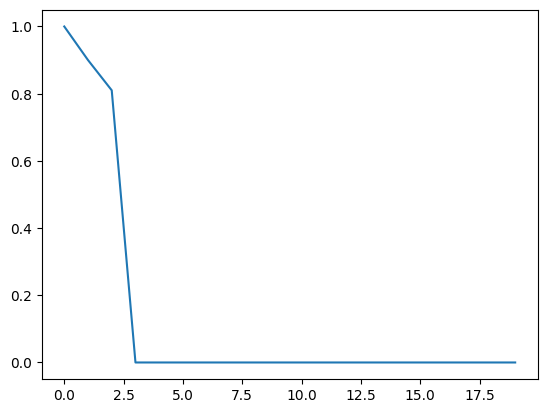

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

residuals = []
for i in range(1, len(Qpi_sequence)):
    residuals.append(np.max(np.abs(Qpi_sequence[i]-Qpi_sequence[i-1])))

plt.plot(residuals)
plt.figure()


### Bellman optimality operator

We can unfold the same kind of reasoning on the value of an optimal policy. We write:
$$V^{\pi^*} = V^*, \quad Q^{\pi^*} = Q^*$$


Any policy $\pi$ defined by $\pi(s) \in \arg\max\limits_{a\in A} Q^*(s,a)$ is an optimal policy.


The optimal value function obeys:
\begin{align*}
    V^*(s) &= \max\limits_{a\in A} \left[ r(s,a) + \gamma \mathbb{E}_{s'\sim p(s'|s,a)} V^*(s') \right]\\
        &= \max\limits_{a\in A} \left[ r(s,a) + \gamma \sum\limits_{s'\in S} p(s'|s,a) V^*(s') \right]
\end{align*}
or in terms of $Q$-functions:
\begin{align*}
    Q^*(s,a) &= r(s,a) + \gamma \mathbb{E}_{s'\sim p(s'|s,a)} \left[ \max_{a'\in A} Q^*(s',a') \right]\\
        &= r(s,a) + \gamma \sum\limits_{s'\in S}p(s'|s,a) \max\limits_{a'\in A} Q^*(s',a')
\end{align*}


We have also defined the **Bellman optimality operator $T^*$** (on $V$ and $Q$ functions) as:

$$\left(T^*V\right)(s) = \max\limits_{a\in A} \left[ r(s,a) + \gamma \mathbb{E}_{s'\sim p(s'|s,a)} V(s') \right]$$
$$\left(T^*Q\right)(s,a) = r(s,a) + \gamma \mathbb{E}_{s'\sim p(s'|s,a)} \left[ \max_{a'\in A} Q(s',a') \right]$$


So finding $V^*$ (resp. $Q^*$) boils down to solving $V= T^* V$ (resp. $Q = T^* Q$).

#### Properties of $T^*$
<ol>
<li> $T^*$ is non-linear.<br>
<li> $T^*$ is a contraction mapping<br>
With $\gamma<1$, $T^*$ is a $\| \cdot \|_\infty$-contraction mapping over the $\mathcal{F}(S,\mathbb{R})$ (resp. $\mathcal{F}(S\times A,\mathbb{R})$) Banach space.<br>
$\Rightarrow$ With $\gamma<1$, $V^*$ (resp. $Q^*$) is the unique solution to the fixed point equation:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$V=T^* V$ (resp. $Q=T^* Q$).
</ol>


### Dynamic Programming for the optimality equation

Repeatedly applying $T^*$ to an initial function $Q_0$ yields the sequence $Q_{n+1} = T^* Q_n$ that converges to $Q^*$.

The implementation of this sequence's computation is the algorithm called **Value Iteration**.

Let's compute the sequence $Q_{n+1} = T^* Q_n$.
</div>

In [21]:
gamma = 0.9
Q = np.zeros((env.observation_space.n, env.action_space.n))
Qopt_sequence = [Q]
for i in range(nb_iter):
    Qnew = np.zeros((env.observation_space.n, env.action_space.n))
    for x in range(env.observation_space.n):
        for a in range(env.action_space.n):
            outcomes = env.unwrapped.P[x][a]
            for o in outcomes:
                p = o[0]
                y = o[1]
                r = o[2]
                Qnew[x,a] += p * (r + np.max(Q[y,:]) )
    Q = Qnew
    Qopt_sequence.append(Q)


Let's plot the sequence of $\| Q_n - Q_{n-1} \|_\infty$ to verify the convergence of the sequence.
</div>

<Figure size 640x480 with 0 Axes>

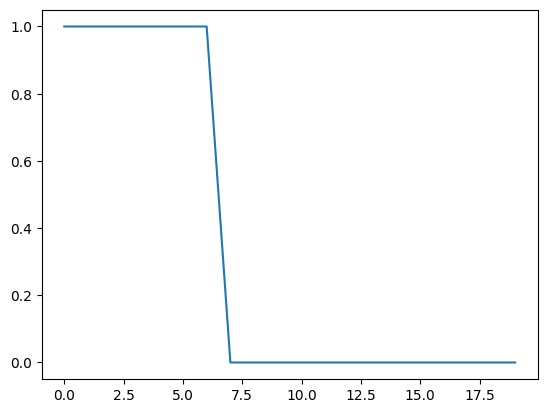

<Figure size 640x480 with 0 Axes>

In [24]:
residuals = []
for i in range(1, len(Qopt_sequence)):
    residuals.append(np.max(np.abs(Qopt_sequence[i]-Qopt_sequence[i-1])))

plt.plot(residuals)
plt.figure()


## <img src="https://img.icons8.com/?size=50&id=104299&format=png&color=000000" style="height:30px;display:inline"> Value Iteration



Value iteration is a method used in dynamic programming to compute the optimal value function $V^*(s)$ and derive the optimal policy $\pi^*$. This method is particularly useful when the reward function and transition probabilities are known, and the state and action spaces are not excessively large.


#### Dynamic Programming

To understand value iteration, let's assume we know the transition probabilities $P(s'|s,a)$ and that both state ($s$) and action ($a$) spaces are small and discrete. This is known as the "known dynamics" setting, which is not typical in model-free reinforcement learning but is useful for deriving the basic algorithm.

In this setting, we can represent the entire state-action space using a table. For instance, in a grid world with 16 states and 4 possible actions (left, right, up, down), we can store the value function $V^\pi(s)$ in a table with 16 entries.

### Value Iteration Algorithm

Value iteration simplifies the policy iteration algorithm by directly computing the optimal value function without explicitly maintaining a policy. The algorithm consists of the following steps:

1. **Initialize** $Q_0(s,a) = 0$ for all $(s,a)$.
2. **Iterate**: For each $n$:
   - Compute the new Q-values:

     $$
     Q_{n+1}(s,a) = \sum_{s'} P(s'|s,a) \left[ r(s,a,s') + \gamma \max_{a'} Q_n(s',a') \right]
     $$

3. **Convergence**: Continue iterating until $Q_n$ converges to $Q^*$.



Once $Q^*(s,a)$ is computed, the optimal policy $\pi^*$ can be derived as:

$$
\pi^*(s) = \arg \max_{a \in A} Q^*(s,a)
$$

<img src='https://github.com/CLAIR-LAB-TECHNION/CLAI/blob/main/tutorials/assets/task_sign.png?raw=true' width=800/>

#### <img src="https://img.icons8.com/?size=50&id=46589&format=png&color=000000" style="height:30px;display:inline"> Task 3: Value iteration

1. (Optimal Value function) Write a function that takes as input an initial state-action value function `Q0` and an environment `env` and returns a vector `Q` such that $||T^* Q -  Q ||_\infty \leq \varepsilon $ and the greedy policy with respect to $Q$.
2. Test the convergence of the function you implemented.

In [34]:
# --------------
# Your answer to 1.
# --------------
def value_iteration(Q0, env, epsilon=1e-5):
    """
    Finding the optimal value function. To be done!
    """
    TQ = 0
    greedy_policy = []
    return TQ, greedy_policy

In [35]:
# --------------
# Your answer to 2.
# --------------

<img src='https://github.com/CLAIR-LAB-TECHNION/CLAI/blob/main/tutorials/assets/solution_sign.png?raw=true' width=800/>

### <img src="https://img.icons8.com/?size=50&id=42816&format=png&color=000000" style="height:30px;display:inline"> Solution

In [39]:
# --------------
# Solution to 1.
# --------------
def value_iteration(Q0, env, epsilon=1e-5):
    """
    Finding the optimal value function. To be done!
    """
    Q = Q0
    while True:
        TQ, greedy_policy = bellman_operator(Q, env)

        err = np.abs(TQ-Q).max()
        if err < epsilon:
            return TQ, greedy_policy

        Q = TQ

In [40]:
# --------------
# Solution to 2.
# --------------
epsilon = 1e-6
Q0 = np.zeros((env.observation_space.n, env.action_space.n))

Q, greedy_policy = value_iteration(Q0, env, epsilon)
err = np.abs(Q - bellman_operator(Q, env)[0]).max()
print("norm of T(Q) - Q = ", err)
assert err <= epsilon

norm of T(Q) - Q =  0.0


#<img src="https://img.icons8.com/?size=50&id=qjEfYyGK_vq-&format=png&color=000000" style="height:30px;display:inline">  Monte Carlo vs Temporal Difference Learning

In reinforcement learning, Monte Carlo (MC) and Temporal Difference (TD) are two fundamental strategies used to train value functions or policy functions. Both methods use experience to solve the reinforcement learning problem, but they differ in how and when they update their value estimates.


<img src='https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/Summary.jpg' width=800/>

### Monte Carlo Learning

Monte Carlo methods update the value function based on the entire episode of experience. This means that the agent interacts with the environment until the episode terminates, and then uses the total accumulated reward (return) to update the value function.




<img src='https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/MC-5.jpg' width=800/>

**Key Characteristics:**
- **Learning at the end of the episode:** The value function is updated only after the episode has concluded.
- **Accurate but high variance:** Since Monte Carlo uses the actual return, the updates are accurate. However, the variance can be high due to the dependence on the entire episode.
- **No bootstrapping:** Monte Carlo methods do not rely on previous estimates; they use the complete return for updates.



**Example Process:**
1. The agent follows a policy to generate an episode consisting of states, actions, rewards, and next states.
2. At the end of the episode, the agent calculates the return $G_t$.
3. The value function $V(S_t)$ is updated based on the return $G_t$.

$$ V(S_t) = V(S_t) + \alpha \left[ G_t - V(S_t) \right] $$

### Temporal Difference Learning

Temporal Difference methods, such as TD(0), update the value function based on a single step of experience. The value function is updated incrementally using the difference between the estimated value and the actual reward plus the discounted value of the next state.



<img src='https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/TD-3.jpg' width=800/>

**Key Characteristics:**
- **Learning at each step:** The value function is updated after each interaction with the environment.
- **Lower variance but biased:** TD methods can have lower variance because they bootstrap, using existing value estimates to update the value function. However, this introduces bias.
- **Bootstrapping:** TD methods update the value function using the estimated return from the current state and action.




**Example Process:**
1. The agent takes an action $A_t$ in state $S_t$, receives a reward $R_{t+1}$, and transitions to the next state $S_{t+1}$.
2. The value function $V(S_t)$ is updated based on the reward and the estimated value of $S_{t+1}$.

$$ V(S_t) = V(S_t) + \alpha \left[ R_{t+1} + \gamma V(S_{t+1}) - V(S_t) \right] $$

# <img src="https://img.icons8.com/?size=50&id=110865&format=png&color=000000" style="height:30px;display:inline"> Q-Learning



Q-Learning is a fundamental algorithm in reinforcement learning that helps in training an action-value function, which we commonly refer to as the Q-function. This Q-function determines the value of being at a particular state and taking a specific action at that state. The key characteristic of Q-Learning is that it uses a Temporal Difference (TD) approach to update its Q-values.

#### Temporal Difference Learning as Stochastic Approximation

Evaluating $Q^\pi(s,a)$ involves estimating the expected return $G^\pi(s,a)$. Stochastic approximation theory provides a way to estimate $Q^\pi(s,a)$ from experience samples rather than from a model. This is achieved through a sequence of updates:

$$ q_{t+1} = q_t + \alpha_t \left(g^\pi_t - q_t\right) $$

where $g^\pi_t$ are independent realizations of $G^\pi(s,a)$ and $\alpha_t$ are step sizes that meet specific conditions to ensure convergence.

This approach can be generalized using Stochastic Gradient Descent (SGD), where $Q^\pi$ minimizes the loss function:

$$ L(Q) = \frac{1}{2} \int_{S \times A} \left[ Q(s,a) - \mathbb{E}\left(G^\pi(s,a)\right) \right]^2 dsda $$

The gradient descent update for this can be approximated using a set of independent state-action pairs, leading to the SGD update:

$$ Q \leftarrow Q - \alpha \sum_{i=1}^N \left[ Q(s_i,a_i) - g^\pi(s_i,a_i) \right] \nabla_Q Q(s_i,a_i) $$

For simplicity, the stochastic approximation perspective is often used, where the update becomes:

$$ Q(s,a) \leftarrow Q(s,a) + \alpha \left(g^\pi(s,a) - Q(s,a) \right) $$


#### Temporal Difference (TD) Learning

TD learning combines ideas from Monte Carlo methods and dynamic programming. It updates the value function after every step using the TD error, which measures the difference between the predicted value and the actual observed value. The TD(0) update for a Q-function is given by:

$$Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \left(r_t + \gamma Q(s_{t+1}, \pi(s_{t+1})) - Q(s_t,a_t)\right).$$

Here, $r_t$ is the reward received, $\gamma$ is the discount factor, and $\pi$ is the policy being evaluated.

**Temporal Difference Error**: The difference $\delta_t = r_t + \gamma Q(s_{t+1}, \pi(s_{t+1})) - Q(s_t,a_t)$ is called the temporal difference (TD) error. It represents the discrepancy between the predicted Q-value and the observed return.

#### Bootstrapping and Convergence

Bootstrapping refers to the use of existing value estimates to update Q-values. This is a core aspect of TD learning, enabling it to update values based on a combination of observed rewards and estimated future values.

For TD(0) to converge to the correct Q-values, the following conditions must be met:
- All state-action pairs must be visited infinitely often.
- The step sizes $\alpha_t$ must satisfy the Robbins-Monro conditions.

## <img src="https://img.icons8.com/?size=50&id=tLpFC4eS6GLY&format=png&color=000000" style="height:30px;display:inline"> Q-Learning Algorithm



<img src='https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/Q-learning-2.jpg' width=800/>

<img src='https://github.com/CLAIR-LAB-TECHNION/CLAI/blob/main/tutorials/assets/task_sign.png?raw=true' width=800/>

## <img src="https://img.icons8.com/?size=50&id=46589&format=png&color=000000" style="height:30px;display:inline"> Task 4: Create and Initialize the Q-table

(Step 1 of the pseudocode)


**Initialize the Q-Table**
   - Create a table $Q$ with all state-action pairs, initialized to zero or some arbitrary value.
   - This table will be updated as the agent learns from its interactions with the environment.





In [61]:
%%script true

state_space =
print("There are ", state_space, " possible states")

action_space =
print("There are ", action_space, " possible actions")

In [62]:
%%script true
# Let's create our Qtable of size (state_space, action_space) and initialized each values at 0 using np.zeros. np.zeros needs a tuple (a,b)
def initialize_q_table(state_space, action_space):
  Qtable =
  return Qtable

In [63]:
Qtable_frozenlake = initialize_q_table(state_space, action_space)

<img src='https://github.com/CLAIR-LAB-TECHNION/CLAI/blob/main/tutorials/assets/solution_sign.png?raw=true' width=800/>

### <img src="https://img.icons8.com/?size=50&id=42816&format=png&color=000000" style="height:30px;display:inline"> Solution

In [45]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

There are  16  possible states
There are  4  possible actions


In [46]:
# Let's create our Qtable of size (state_space, action_space) and initialized each values at 0 using np.zeros
def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space, action_space))
  return Qtable

In [47]:
Qtable_frozenlake = initialize_q_table(state_space, action_space)

## <img src="https://img.icons8.com/?size=50&id=42957&format=png&color=000000" style="height:30px;display:inline"> Greedy policy



Remember we have two policies since Q-Learning is an **off-policy** algorithm. This means we're using a **different policy for acting and updating the value function**.

- Epsilon-greedy policy (acting policy)
- Greedy-policy (updating policy)

The greedy policy will also be the final policy we'll have when the Q-learning agent completes training. The greedy policy is used to select an action using the Q-table.

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/off-on-4.jpg" alt="Q-Learning" width="100%"/>


### <img src="https://img.icons8.com/?size=50&id=46589&format=png&color=000000" style="height:30px;display:inline"> Task 5: Define the greedy policy

In [64]:
%%script true

def greedy_policy(Qtable, state):
  # Exploitation: take the action with the highest state, action value
  action =

  return action

<img src='https://github.com/CLAIR-LAB-TECHNION/CLAI/blob/main/tutorials/assets/solution_sign.png?raw=true' width=800/>

#### <img src="https://img.icons8.com/?size=50&id=42816&format=png&color=000000" style="height:30px;display:inline"> Solution

In [65]:
def greedy_policy(Qtable, state):
  # Exploitation: take the action with the highest state, action value
  action = np.argmax(Qtable[state][:])

  return action

## <img src="https://img.icons8.com/?size=50&id=fMIqNhC5krWZ&format=png&color=000000" style="height:30px;display:inline"> Epsilon-greedy policy



Epsilon-greedy is the training policy that handles the exploration/exploitation trade-off.

The idea with epsilon-greedy:

- With *probability 1 - ɛ* : **we do exploitation** (i.e. our agent selects the action with the highest state-action pair value).

- With *probability ɛ*: we do **exploration** (trying a random action).

As the training continues, we progressively **reduce the epsilon value since we will need less and less exploration and more exploitation.**

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/Q-learning-4.jpg" alt="Q-Learning" width="100%"/>


#### Exploration vs. Exploitation Tradeoff

Balancing exploration and exploitation is crucial in Q-Learning. The $\epsilon$-greedy strategy is commonly used to address this tradeoff:
- **Exploration**: Trying new actions to discover their effects and gather more information.
- **Exploitation**: Using known information to maximize the immediate reward.


At the beginning of the training, the probability of doing exploration will be huge since ɛ is very high, so most of the time, we’ll explore. But as the training goes on, and consequently our Q-table gets better and better in its estimations, we progressively reduce the epsilon value since we will need less and less exploration and more exploitation.

As training progresses, the value of $\epsilon$ is gradually reduced to shift the focus from exploration to exploitation, leveraging the learned Q-values to make better decisions.

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/Q-learning-5.jpg" alt="Q-Learning" width="70%"/>

### <img src="https://img.icons8.com/?size=50&id=46589&format=png&color=000000" style="height:30px;display:inline"> Task 6: Define the epsilon greedy policy

In [66]:
%%script true
def epsilon_greedy_policy(Qtable, state, epsilon):
  # Randomly generate a number between 0 and 1
  random_num =
  # if random_num > greater than epsilon --> exploitation
  if random_num > epsilon:
    # Take the action with the highest value given a state
    # np.argmax can be useful here
    action =
  # else --> exploration
  else:
    action = # Take a random action

  return action

<img src='https://github.com/CLAIR-LAB-TECHNION/CLAI/blob/main/tutorials/assets/solution_sign.png?raw=true' width=800/>

#### <img src="https://img.icons8.com/?size=50&id=42816&format=png&color=000000" style="height:30px;display:inline"> Solution

In [50]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  # Randomly generate a number between 0 and 1
  random_num = random.uniform(0,1)
  # if random_num > greater than epsilon --> exploitation
  if random_num > epsilon:
    # Take the action with the highest value given a state
    # np.argmax can be useful here
    action = greedy_policy(Qtable, state)
  # else --> exploration
  else:
    action = env.action_space.sample()

  return action

## <img src="https://img.icons8.com/?size=50&id=104321&format=png&color=000000" style="height:30px;display:inline"> The training loop method



<img src="https://cdn-media-1.freecodecamp.org/images/TnN7ys7VGKoDszzv3WDnr5H8txOj3KKQ0G8o">

The training loop goes like this:

```
For episode in the total of training episodes:

Reduce epsilon (since we need less and less exploration)
Reset the environment

  For step in max timesteps:    
    Choose the action At using epsilon greedy policy
    Take the action (a) and observe the outcome state(s') and reward (r)
    Update the Q-value Q(s,a) using Bellman equation Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
    If done, finish the episode
    Our next state is the new state
```

### <img src="https://img.icons8.com/?size=50&id=46589&format=png&color=000000" style="height:30px;display:inline"> Task 7: Create the training loop

In [67]:
%%script true

def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  for episode in tqdm(range(n_training_episodes)):
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state, info = env.reset()
    step = 0
    terminated = False
    truncated = False

    # repeat
    for step in range(max_steps):
      # Choose the action At using epsilon greedy policy
      action =

      # Take action At and observe Rt+1 and St+1
      # Take the action (a) and observe the outcome state(s') and reward (r)
      new_state, reward, terminated, truncated, info =

      # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
      Qtable[state][action] =

      # If terminated or truncated finish the episode
      if terminated or truncated:
        break

      # Our next state is the new state
      state = new_state
  return Qtable

<img src='https://github.com/CLAIR-LAB-TECHNION/CLAI/blob/main/tutorials/assets/solution_sign.png?raw=true' width=800/>

#### <img src="https://img.icons8.com/?size=50&id=42816&format=png&color=000000" style="height:30px;display:inline"> Solution

In [52]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  for episode in tqdm(range(n_training_episodes)):
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state, info = env.reset()
    step = 0
    terminated = False
    truncated = False

    # repeat
    for step in range(max_steps):
      # Choose the action At using epsilon greedy policy
      action = epsilon_greedy_policy(Qtable, state, epsilon)

      # Take action At and observe Rt+1 and St+1
      # Take the action (a) and observe the outcome state(s') and reward (r)
      new_state, reward, terminated, truncated, info = env.step(action)

      # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
      Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action])

      # If terminated or truncated finish the episode
      if terminated or truncated:
        break

      # Our next state is the new state
      state = new_state
  return Qtable

## <img src="https://img.icons8.com/?size=50&id=43434&format=png&color=000000" style="height:30px;display:inline"> Define the hyperparameters



The exploration related hyperparamters are some of the most important ones.

- We need to make sure that our agent **explores enough of the state space** to learn a good value approximation. To do that, we need to have progressive decay of the epsilon.
- If you decrease epsilon too fast (too high decay_rate), **you take the risk that your agent will be stuck**, since your agent didn't explore enough of the state space and hence can't solve the problem.

In [54]:
# Training parameters
n_training_episodes = 10000  # Total training episodes
learning_rate = 0.7          # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# Environment parameters
env_id = "FrozenLake-v1"     # Name of the environment
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate
eval_seed = []               # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability
decay_rate = 0.0005            # Exponential decay rate for exploration prob

## <img src="https://img.icons8.com/?size=50&id=xqc9b4R1mo2b&format=png&color=000000" style="height:30px;display:inline"> Train the Q-Learning agent



In [55]:
Qtable_frozenlake = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

  0%|          | 0/10000 [00:00<?, ?it/s]

Let's see what our Q-Learning table looks like now

In [56]:
Qtable_frozenlake

array([[0.73509189, 0.77378094, 0.77378094, 0.73509189],
       [0.73509189, 0.        , 0.81450625, 0.77378094],
       [0.77378094, 0.857375  , 0.77378094, 0.81450625],
       [0.81450625, 0.        , 0.77378094, 0.77378094],
       [0.77378094, 0.81450625, 0.        , 0.73509189],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.        , 0.81450625],
       [0.        , 0.        , 0.        , 0.        ],
       [0.81450625, 0.        , 0.857375  , 0.77378094],
       [0.81450625, 0.9025    , 0.9025    , 0.        ],
       [0.857375  , 0.95      , 0.        , 0.857375  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.95      , 0.857375  ],
       [0.9025    , 0.95      , 1.        , 0.9025    ],
       [0.        , 0.        , 0.        , 0.        ]])

## <img src="https://img.icons8.com/?size=50&id=43157&format=png&color=000000" style="height:30px;display:inline">  The evaluation method



- We defined the evaluation method that we're going to use to test our Q-Learning agent.

In [68]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param max_steps: Maximum number of steps per episode
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param Q: The Q-table
  :param seed: The evaluation seed array (for taxi-v3)
  """
  episode_rewards = []
  for episode in tqdm(range(n_eval_episodes)):
    if seed:
      state, info = env.reset(seed=seed[episode])
    else:
      state, info = env.reset()
    step = 0
    truncated = False
    terminated = False
    total_rewards_ep = 0

    for step in range(max_steps):
      # Take the action (index) that have the maximum expected future reward given that state
      action = greedy_policy(Q, state)
      new_state, reward, terminated, truncated, info = env.step(action)
      total_rewards_ep += reward

      if terminated or truncated:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

#### Convergence

Q-Learning converges to the optimal Q-values $Q^*$ under certain conditions:
- **Exploration**: All state-action pairs must be visited infinitely often to ensure comprehensive learning.
- **Learning Rate**: The learning rate $\alpha$ must meet the Robbins-Monro conditions: $\sum_t \alpha_t = \infty$ and $\sum_t \alpha_t^2 < \infty$. These conditions ensure that the learning rate decreases over time, allowing for stable updates.




#### Evaluate our Q-Learning agent

- Usually, you should have a mean reward of 1.0
- The **environment is relatively easy** since the state space is really small (16). What you can try to do is [to replace it with the slippery version](https://gymnasium.farama.org/environments/toy_text/frozen_lake/), which introduces stochasticity, making the environment more complex.

In [58]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Mean_reward=1.00 +/- 0.00


# <img src="https://img.icons8.com/?size=100&id=46509&format=png&color=000000" style="height:50px;display:inline"> Conclusion
---

In this tutorial, we delved into several key concepts and methodologies fundamental to value-based reinforcement learning. Our journey began with an exploration of value functions, the backbone of understanding the expected return from states and actions under a given policy. We then introduced the Bellman equations, which provide a recursive decomposition of value functions and are pivotal for various RL algorithms.

We moved on to Temporal Difference (TD) learning, a powerful approach that combines the ideas of Monte Carlo methods and dynamic programming to update value estimates based on observed rewards. This method serves as the foundation for many RL algorithms, including the widely used Q-learning.

Value iteration was also discussed as a method for computing optimal policies by iteratively improving value function estimates. We examined how this process converges to the optimal value function, providing a robust way to solve Markov Decision Processes (MDPs).

Finally, we focused on Q-learning, a model-free, off-policy algorithm that updates Q-values using the Bellman optimality equation. This method allows agents to learn optimal policies through interaction with the environment, balancing exploration and exploitation to improve decision-making over time.






# <img src="https://img.icons8.com/dusk/64/000000/plus-2-math.png" style="height:50px;display:inline"> Further Reading
---


For a deeper understanding of value-based methods and Q-Learning, explore the following resources:

- **Hugging Face Deep RL Course - Q-Learning**: A comprehensive guide to Q-Learning, covering theory and practical implementation. [Read more](https://huggingface.co/learn/deep-rl-course/unit2/q-learning)
- **Towards Data Science - Q-Learning Algorithm**: An intuitive explanation and step-by-step implementation of Q-Learning in Python. [Read more](https://towardsdatascience.com/q-learning-algorithm-from-explanation-to-implementation-cdbeda2ea187)
- **Advanced Readings in Reinforcement Learning**: Detailed proofs and theoretical discussions on advanced RL topics. [Access the document](https://drive.google.com/file/d/1004d-GVvXuI7vgLpzPvoESeP5jyERw9Z/view)






# <img src="https://img.icons8.com/?size=100&id=46756&format=png&color=000000" style="height:50px;display:inline"> Credits
---
* Examples and code snippets were taken from <a href="https://huggingface.co/learn/deep-rl-course/unit4/introduction"> Hugging Face Deep RL Course </a>
* Examples and explanations were taken from <a href="https://rail.eecs.berkeley.edu/deeprlcourse/">CS285 - Deep Reinforcement Learning Course at UC Berkeley</a>
* Icons from <a href="https://icons8.com/">Icons8.com